<div style="border:solid green 2px; padding: 20px"> <h1 style="color:green; margin-bottom:20px">Комментарий наставника</h1>

Привет! Далее в файле мои коммефнтарии ты сможешь найти в ячейках, аналогичных данной ( если рамки комментария зелёные - всё сделано правильно; жёлтые - есть замечания, но не критично; красные - нужно переделать). Не удаляй эти комментарии и постарайся учесть их в ходе выполнения проекта. 

# Шаг 0. Введение

Задача анализа - разобраться, как ведут себя пользователи мобильного приложения для онлайн покупок.
Изучим воронку продаж и исследуем результаты A/B-эксперимента со шрифтом.

In [97]:
import pandas as pd
import matplotlib as plt
import seaborn as sns
import datetime as dt
import scipy.stats as st
import numpy as np
import math as mth

# Шаг 1. Откроем файл с данными и изучим общую информацию

In [98]:
df=pd.read_csv('/datasets/logs_exp.csv', sep='\t')
df

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
EventName         244126 non-null object
DeviceIDHash      244126 non-null int64
EventTimestamp    244126 non-null int64
ExpId             244126 non-null int64
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Типы данных для столбцов указаны верно. Пропуски отсутствуют 

# Шаг 2. Подготовим данные для анализа

Переименуем столбцы

In [100]:
df.columns=('event','user','stamp','exper')

Удалим дубликаты

In [101]:
df.duplicated().value_counts()

False    243713
True        413
dtype: int64

In [102]:
df=df.drop_duplicates()

In [103]:
df.duplicated().value_counts()

False    243713
dtype: int64

Добавим столбец даты и времени

In [104]:
df['time']=pd.to_datetime(df.stamp, unit='s')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


а также отдельный столбец с датами

In [105]:
df['date']=df['time'].dt.date

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Посмотрим, что получилось

In [106]:
df

,event,user,stamp,exper,time,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25
...,...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21:12:25,2019-08-07
244122,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59,2019-08-07
244123,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43,2019-08-07
244124,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58,2019-08-07


# Шаг 3. Изучим и проверим данные

Узнаем сколько всего событий в логе

In [107]:
df.event.count()

243713

Посчитаем количество пользователей в логе

In [108]:
len(df.user.unique())

7551

Посмотрим сколько в среднем событий приходится на пользователя

In [109]:
round(df.groupby('user')['event'].count().mean(),1)

32.3

Найдем максимальную дату в логе 

In [110]:
df.date.max()

datetime.date(2019, 8, 7)

Найдем минимальную дату в логе 

In [111]:
df.date.min()

datetime.date(2019, 7, 25)

Построим гистограмму по дате и времени

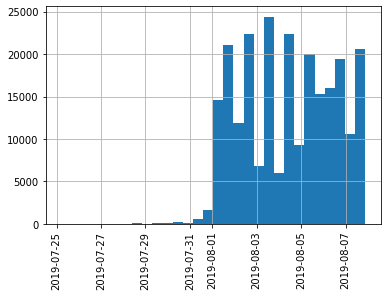

In [112]:
df.time.hist(bins=30, xrot=90)

К сожалению данных за июль очень мало. Оставим лог за август

In [113]:
df2=df[df['date']>dt.date(2019,7,31)]

Проверим много ли событий и пользователей мы потеряли, отбросив старые данные

In [114]:
round((len(df)-len(df2))/len(df),3)

0.012

Оказывается, мы лишились всего 1% данных

<div style="border:solid green 2px; padding: 20px"> <h1 style="color:green; margin-bottom:20px">Комментарий наставника</h1>

Ок, здесь все верно рассчитано. 

-------------------------------------------------------------------------------------------------------

Проверим, что сохранились пользователи из всех трёх экспериментальных групп

In [115]:
df.groupby('exper')['user'].nunique()

exper
246    2489
247    2520
248    2542
Name: user, dtype: int64

Все в порядке. Количество пользователtq примерно одинаковое

<div style="border:solid green 2px; padding: 20px"> <h1 style="color:green; margin-bottom:20px">Комментарий наставника</h1>

Да, группы равнозначны, можно переходить к воронке. 

# Шаг 4. Изучим воронку событий

Посмотрим, какие события есть в логах, как часто они встречаются и отсортируем по частоте

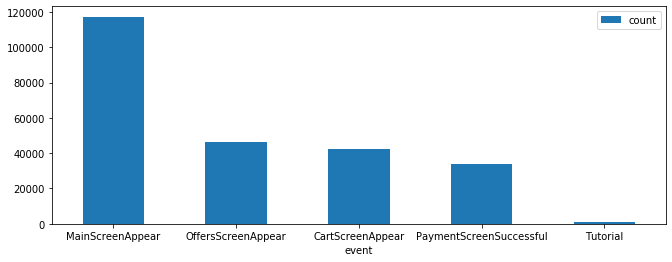

In [116]:
voronka=df2.event.value_counts().reset_index()
voronka.columns=('event','count')
voronka.plot(y='count', x='event', kind='bar', rot=0, figsize=(11,4))

Посчитаем, сколько пользователей совершали каждое из этих событий

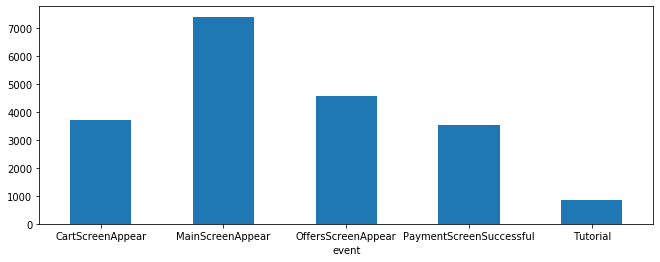

In [117]:
df2.groupby('event')['user'].nunique().plot(kind='bar', rot=0, figsize=(11,4))

Отсортируем события и посчитаем долю пользователей, которые хоть раз совершали событие

In [118]:
voronka=voronka.merge(df2.groupby('event')['user'].nunique().reset_index().sort_values(by='user', ascending=False), on='event')

In [119]:
voronka['percent']=(voronka['user']/voronka['user'].sum()*100).round(2)
voronka

,event,count,user,percent
0,MainScreenAppear,117328,7419,36.86
1,OffersScreenAppear,46333,4593,22.82
2,CartScreenAppear,42303,3734,18.55
3,PaymentScreenSuccessful,33918,3539,17.59
4,Tutorial,1005,840,4.17


Предположим порядок событий на экране


<div style="border:solid yellow 2px; padding: 20px"> <h1 style="color:yellow; margin-bottom:20px">Комментарий наставника</h1>

здесь все таки не совсем то имелось ввиду отношение к общему числу пользователей, т.е voronka.user/df2.user.unique()*100. 

Tutorial - MainScreenAppear -  OffersScreenAppear - CartScreenAppear - PaymentScreenSuccessful

Видимо экран Tutorial пользователи часто пропускают, поэтому он оказался в конце частотного списка

-------------------------------------------------------------------------------------------------------

По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки

In [120]:
voronka['dolya']=(voronka['user']/voronka['user'].shift()*100).round(1)
voronka.ix[0,'dolya']=100
voronka

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  


,event,count,user,percent,dolya
0,MainScreenAppear,117328,7419,36.86,100.0
1,OffersScreenAppear,46333,4593,22.82,61.9
2,CartScreenAppear,42303,3734,18.55,81.3
3,PaymentScreenSuccessful,33918,3539,17.59,94.8
4,Tutorial,1005,840,4.17,23.7


Больше всего пользователей теряется на главном экране

-------------------------------------------------------------------------------------------------------

Узнаем какой процент пользователей доходит от первого события до оплаты

In [121]:
round((voronka.iloc[3]['user']/voronka.iloc[0]['user']*100),1)

47.7

<div style="border:solid red 2px; padding: 20px"> <h1 style="color:red; margin-bottom:20px">Комментарий наставника</h1>

Воронка рассчитана не верно. При анализе воронки надо:
    1. посчитать количество пользователей на каждом этапе
    2. определить долю пользователей, т.е отношение пользователей на определенном шаге к общему количеству пользователей
    3. определить цепочку действий и исключить дополнительное\необязательное действие
    4. определить воронку, т.е. отношение числа пользователей на шаге к числу пользователей на предыдущем шаге


<div style="border:solid green 2px; padding: 20px"> <h1 style="color:green; margin-bottom:20px">Комментарий наставника</h1>

Теперь в целом все верно. 

# Шаг 5. Изучим результаты эксперимента

Посмотрим сколько пользователей в каждой экспериментальной группе

In [122]:
df2.groupby('exper')['user'].nunique()

exper
246    2484
247    2513
248    2537
Name: user, dtype: int64

Посчитаем количество пользователей для каждого события в каждой из котрольных групп

In [123]:
d246=df2[df2['exper']==246]
d247=df2[df2['exper']==247]

In [124]:
con246=d246.groupby('event')['user'].nunique().reset_index().sort_values(by='user', ascending=False)
con246

,event,user
1,MainScreenAppear,2450
2,OffersScreenAppear,1542
0,CartScreenAppear,1266
3,PaymentScreenSuccessful,1200
4,Tutorial,278


In [125]:
con247=d247.groupby('event')['user'].nunique().reset_index().sort_values(by='user', ascending=False)
con247

,event,user
1,MainScreenAppear,2476
2,OffersScreenAppear,1520
0,CartScreenAppear,1238
3,PaymentScreenSuccessful,1158
4,Tutorial,283


Проверим, находят ли статистические критерии разницу между выборками 246 и 247

In [126]:
def proverka(successes, trials):
    alpha = .04 # критический уровень статистической значимости
    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    distr = st.norm(0, 1) 

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', round(p_value,3))

    if (p_value < alpha):
        print("между долями есть значимая разница")
    else:
        print("нет оснований считать доли разными")

<div style="border:solid green 2px; padding: 20px"> <h1 style="color:green; margin-bottom:20px">Комментарий наставника</h1>

Функция для проверки написана верно. 

Для этого посчитаем конверсию (отношение числа пользователей совершивших PaymentScreenSuccessful к числу MainScreenAppear)

In [127]:
successes = np.array([con246.iloc[3]['user'], con247.iloc[3]['user']])
trials = np.array([con246.iloc[0]['user'], con247.iloc[0]['user']])

In [128]:
proverka(successes, trials)

p-значение:  0.12
нет оснований считать доли разными


Выберем самое популярное событие 'MainScreenAppear' и посчитаем долю пользователей, совершивших это событие

In [129]:
successes = np.array([con246.iloc[0]['user'], con247.iloc[0]['user']])
trials = np.array([con246['user'].sum(), con247['user'].sum()])

доля в 1ой группе:

In [130]:
round(successes[0]/trials[0],3)

0.364

доля во 2ой группе:

In [131]:
round(successes[1]/trials[1],3)

0.371

Проверим, будет ли отличие между группами статистически достоверным

In [132]:
proverka(successes, trials)

p-значение:  0.386
нет оснований считать доли разными


-------------------------------------------------------------------------------------------------------

Проверим отличие между группами для всех других событий

In [133]:
def superpro(data1, data2):
    print('Tutorial')
    successes = np.array([data1.iloc[4]['user'], data2.iloc[4]['user']])
    trials = np.array([data1['user'].sum(), data2['user'].sum()])
    proverka(successes, trials)
    
    print('Offers')
    successes = np.array([data1.iloc[1]['user'], data2.iloc[1]['user']])
    trials = np.array([data1['user'].sum(), data2['user'].sum()])
    proverka(successes, trials)
    
    print('Cart')
    successes = np.array([data1.iloc[2]['user'], data2.iloc[2]['user']])
    trials = np.array([data1['user'].sum(), data2['user'].sum()])
    proverka(successes, trials)
    
    print('Payment')
    successes = np.array([data1.iloc[2]['user'], data2.iloc[2]['user']])
    trials = np.array([data1['user'].sum(), data2['user'].sum()])
    proverka(successes, trials)

In [134]:
superpro(con246, con247)

Tutorial
p-значение:  0.745
нет оснований считать доли разными
Offers
p-значение:  0.868
нет оснований считать доли разными
Cart
p-значение:  0.713
нет оснований считать доли разными
Payment
p-значение:  0.713
нет оснований считать доли разными


-------------------------------------------------------------------------------------------------------

Аналогично поступим с группой d248 с изменённым шрифтом

In [135]:
d248=df2[df2['exper']==248]
con248=d248.groupby('event')['user'].nunique().reset_index().sort_values(by='user', ascending=False)
con248

,event,user
1,MainScreenAppear,2493
2,OffersScreenAppear,1531
0,CartScreenAppear,1230
3,PaymentScreenSuccessful,1181
4,Tutorial,279


Проверяем конверсию

In [136]:
successes = np.array([con248.iloc[3]['user'], con246.iloc[3]['user']])
trials = np.array([con248.iloc[0]['user'], con246.iloc[0]['user']])

In [137]:
proverka(successes, trials)

p-значение:  0.258
нет оснований считать доли разными


In [138]:
successes = np.array([con248.iloc[3]['user'], con247.iloc[3]['user']])
trials = np.array([con248.iloc[0]['user'], con247.iloc[0]['user']])

In [139]:
proverka(successes, trials)

p-значение:  0.67
нет оснований считать доли разными


Проверяем событие MainScreenAppear

In [140]:
successes = np.array([con248.iloc[0]['user'], con246.iloc[0]['user']])
trials = np.array([con248['user'].sum(), con246['user'].sum()])

In [141]:
proverka(successes, trials)

p-значение:  0.361
нет оснований считать доли разными


In [142]:
successes = np.array([con248.iloc[0]['user'], con247.iloc[0]['user']])
trials = np.array([con248['user'].sum(), con247['user'].sum()])

In [143]:
proverka(successes, trials)

p-значение:  0.964
нет оснований считать доли разными


Сравним результаты с каждой из контрольных групп в отдельности по остальным событиям

In [144]:
superpro(con248, con247)

Tutorial
p-значение:  0.808
нет оснований считать доли разными
Offers
p-значение:  0.965
нет оснований считать доли разными
Cart
p-значение:  0.735
нет оснований считать доли разными
Payment
p-значение:  0.735
нет оснований считать доли разными


In [145]:
superpro(con248, con246)

Tutorial
p-значение:  0.934
нет оснований считать доли разными
Offers
p-значение:  0.902
нет оснований считать доли разными
Cart
p-значение:  0.479
нет оснований считать доли разными
Payment
p-значение:  0.479
нет оснований считать доли разными


Сравним результаты с объединённой контрольной группой

In [146]:
con=con247
con['user']=con247['user']+con246['user']
con

,event,user
1,MainScreenAppear,4926
2,OffersScreenAppear,3062
0,CartScreenAppear,2504
3,PaymentScreenSuccessful,2358
4,Tutorial,561


Проверим конверсии

In [147]:
successes = np.array([con248.iloc[3]['user'], con.iloc[3]['user']])
trials = np.array([con248.iloc[0]['user'], con.iloc[0]['user']])

In [148]:
proverka(successes, trials)

p-значение:  0.686
нет оснований считать доли разными


Проверим MainScreenAppear

In [149]:
successes = np.array([con248.iloc[0]['user'], con.iloc[0]['user']])
trials = np.array([con248['user'].sum(), con['user'].sum()])

In [150]:
proverka(successes, trials)

p-значение:  0.579
нет оснований считать доли разными


Проверим доли событий

In [151]:
superpro(con248, con)

Tutorial
p-значение:  0.926
нет оснований считать доли разными
Offers
p-значение:  0.963
нет оснований считать доли разными
Cart
p-значение:  0.546
нет оснований считать доли разными
Payment
p-значение:  0.546
нет оснований считать доли разными


Таким образом было проведено 24 проверки статистических гипотез. При уровне значимости 0.04 каждый двадцать пятый раз можно получать ложный результат. Использованный уровень занчимости приемлимый

<div style="border:solid red 2px; padding: 20px"> <h1 style="color:red; margin-bottom:20px">Комментарий наставника</h1>

Проверка гипотез выполнена не верно. 
    
    
Ты не правильно оцениваешь число успехов и попыток.


<div style="border:solid green 2px; padding: 20px"> <h1 style="color:green; margin-bottom:20px">Комментарий наставника</h1>

Все верно. 

# Шаг  6. Выводы

- Лог за июль содержит очень мало данных для  анализа
- Конверсия приложения составила почти 50%
- Контрольные выборки оказались равнозначны
- Между контрольными и экспериментальной выборкой нет отличий


<div style="border:solid green 2px; padding: 20px"> <h1 style="color:green; margin-bottom:20px">Комментарий наставника</h1>

 Проект выполнен хорошо, молодец. 